In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Library

##Installation

In [ ]:
!pip3 install ipdb
!pip3 install tqdm

     |████████████████████████████████| 788kB 5.3MB/s 
     |████████████████████████████████| 368kB 9.5MB/s 
  Created wheel for ipdb: filename=ipdb-0.13.7-cp37-none-any.whl size=11434 sha256=293730eb373766d2563dd426b2f7c2ee0f3e42c1ca66e44cffc577145789a4c1
  Stored in directory: /root/.cache/pip/wheels/69/e2/66/bde554f8029ad1c5288f3bf427a78b18ec670182d7e670efe6
Successfully built ipdb
ERROR: jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.18 which is incompatible.
ERROR: google-colab 1.0.0 has requirement ipython~=5.5.0, but you'll have ipython 7.22.0 which is incompatible.
  Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0


## Import library

In [ ]:
import ipdb
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.cuda as cuda
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from os import listdir
import copy
import pdb
from tqdm import tqdm
from pathlib import Path
from torch.utils.data import DataLoader

import pandas as pd

%matplotlib inline
from PIL import Image, ImageEnhance

plt.ion()   # interactive mode

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cuda:0


In [ ]:
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

Train on gpu: True


# Functions

## downsample

In [ ]:
def downsampler(train_set):
  all =[]
  hem =[]

  for data in train_set:
    if data[1] == 1:
      hem.append(data)
    elif data[1] == 0:
      all.append(data)

  train_set_downsample = []

  for new_data in hem:
    train_set_downsample.append(new_data)

  for new_data in all[0:len(hem)]:
    train_set_downsample.append(new_data)
  
  return train_set_downsample

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(1)  # pause a bit so that plots are updated

#Data Preparation

## Data import & transform

In [ ]:
trainroot_0 = '/content/drive/MyDrive/Dataset/Dataset_Leukemia/C-NMC_training_data/fold_0'
trainroot_1 = '/content/drive/MyDrive/Dataset/Dataset_Leukemia/C-NMC_training_data/fold_1'
trainroot_2 = '/content/drive/MyDrive/Dataset/Dataset_Leukemia/C-NMC_training_data/fold_2'

In [ ]:
transform1 = transforms.Compose([
                                 transforms.CenterCrop((300,300)),
                                 transforms.Resize((224,224)),
                                 transforms.ToTensor()
                                 ])

transform2 = transforms.Compose([
                                 transforms.CenterCrop((300,300)),
                                 transforms.Resize((256,256)),
                                 transforms.ToTensor()
                                  ])

In [ ]:
data_label = datasets.ImageFolder(trainroot_0, transform1)

In [ ]:
dataset1 = torch.utils.data.ConcatDataset([datasets.ImageFolder(root=trainroot_0, transform=transform1),
                                          datasets.ImageFolder(root=trainroot_1, transform=transform1),
                                          datasets.ImageFolder(root=trainroot_2, transform=transform1)
                                          ])
dataset2 = torch.utils.data.ConcatDataset([datasets.ImageFolder(root=trainroot_0, transform=transform2),
                                          datasets.ImageFolder(root=trainroot_1, transform=transform2),
                                          datasets.ImageFolder(root=trainroot_2, transform=transform2)
                                          ])

## Spliting train val & sampling

In [ ]:
from sklearn.model_selection import train_test_split
train_set1, val_set1 = train_test_split(dataset1, test_size=0.3, random_state=42)
train_set2, val_set2 = train_test_split(dataset2, test_size=0.3, random_state=42)

In [ ]:
downsampler1 = downsampler(train_set1)
downsampler2 = downsampler(train_set2)

In [ ]:
dataloaders1 = {
    'train': DataLoader(downsampler1, batch_size=32, shuffle=True),
    'val': DataLoader(val_set1, batch_size=32, shuffle=True)
}
dataloaders2 = {
    'train': DataLoader(downsampler2, batch_size=32, shuffle=True),
    'val': DataLoader(val_set2, batch_size=32, shuffle=True)
}

##show sample data

In [ ]:
trainiter = iter(dataloaders1['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [ ]:
class_names = data_label.classes
class_names

['hem', 'limfoblast']

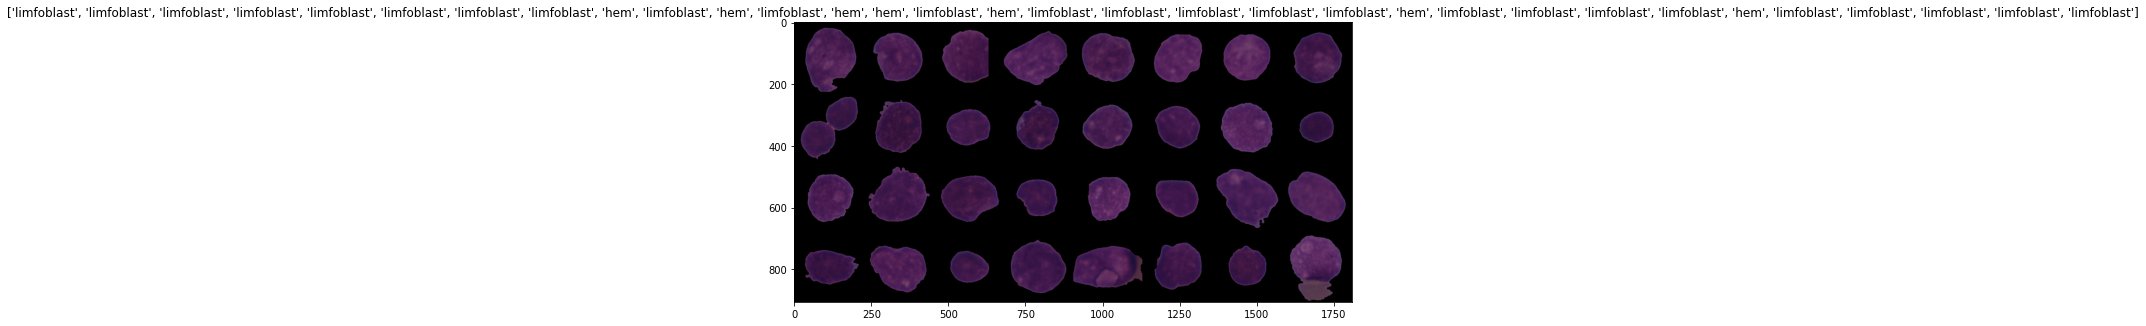

In [ ]:
plt.figure(figsize=(10, 40))

d = torchvision.utils.make_grid(features)
imshow(d, title=[class_names[x] for x in labels])

#Preparing Model & Training function

## Model function

In [ ]:
def pretrained_model(model_name):
  if model_name == 'densenet201':
      model = models.densenet201(pretrained=True)

      n_inputs = model.classifier.in_features
      # Add on classifier
      model.classifier = nn.Sequential(
          nn.Linear(n_inputs, 1000),
          nn.ReLU(),
          nn.Dropout(0.2),
          nn.Linear(1000, 2),
          nn.Softmax(dim=1)
        )
  elif model_name == 'wideresnet50':
      model = models.wide_resnet50_2(pretrained=True)

      n_inputs = model.fc.in_features
      model.fc = nn.Sequential(
          nn.Linear(n_inputs, 1000),
          nn.ReLU(),
          nn.Dropout(0.2),
          nn.Linear(1000, 2),
          nn.Softmax(dim=1)
        )
  elif model_name == 'resnet50':
      model = models.resnet50(pretrained=True)
      n_inputs = model.fc.in_features
      
      # Add on classifier
      model.fc = nn.Sequential(
          nn.Linear(n_inputs, 1000),
          nn.ReLU(),
          nn.Dropout(0.2),
          nn.Linear(1000, 2),
          nn.Softmax(dim=1)
        )

  return model

## Training functions

In [ ]:
def best_result(model_weight, epoch_loss, epoch_acc, sensitivity, specificity):
  best_record =[]

  best_acc = epoch_acc
  best_loss = epoch_loss
  best_sens = sensitivity
  best_spec = specificity
  best_model_wts = copy.deepcopy(model_weight)

  best_record.append([best_acc, best_loss, best_sens, best_spec])
  best_record = pd.DataFrame(best_record, columns=['acc', 'loss', 'sensitivity', 'specificity'])

  return best_record, best_model_wts

In [ ]:
def show_result(since, best_record):
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Acc: {:.4f} | Loss: {:.4f} | Sensitivity: {:.4f} | Specificity: {:.4f}'.format(best_record['acc'][0], best_record['loss'][0], best_record['sensitivity'][0], best_record['specificity'][0]))

In [ ]:
def conf_matrix(preds, labels):
  tp = 0
  tn = 0
  fp = 0
  fn = 0
  
  for pred, label in zip(preds, labels):
    if (label == torch.tensor(1)) and (pred == torch.tensor(1)):
      tp += 1
    elif (label == torch.tensor(1)) and (pred == torch.tensor(0)):
      fp += 1
    elif (label == torch.tensor(0)) and (pred == torch.tensor(0)):
      tn += 1
    elif (label == torch.tensor(0)) and (pred == torch.tensor(1)):
      fn += 1

  return tp, tn, fp, fn

In [ ]:
def metrics(phase, running_loss, running_corrects, dataloaders, tp, tn, fp, fn):
  epoch_loss = running_loss / len(dataloaders[phase].dataset)
  epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
  
  if (tp+fn) == 0:
    sensitivity = 0
  else:
    sensitivity = tp/(tp+fn)

  if (tn+fp) == 0:
    specificity = 0
  else:
    specificity = tn/(tn+fp)

  return epoch_loss, epoch_acc, sensitivity, specificity

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, scheduler_mode= True, max_epochs_stop=5):
    since = time.time()
    state = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = []
    loss_before = np.Inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_tp = 0
            running_tn = 0
            running_fp = 0
            running_fn = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                tp, tn, fp, fn = conf_matrix(preds, labels)

                running_tp += tp
                running_tn += tn
                running_fp += fp
                running_fn += fn

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if (phase == 'train') and (scheduler_mode == True):
              scheduler.step()

            epoch_loss, epoch_acc, sensitivity, specificity = metrics(phase, running_loss, running_corrects, dataloaders, running_tp, running_tn, running_fp, running_fn)           

            if phase == 'val' and epoch_loss >= loss_before:
              state +=1
              if state >= max_epochs_stop:
                print(f'\nEarly Stopping! Total epochs: {epoch}.')
                history.append([phase, epoch_loss, epoch_acc, sensitivity, specificity])
                
                if phase == 'val' and epoch_acc > best_acc:
                  best_record, best_model_wts = best_result(model.state_dict(), epoch_loss, epoch_acc, sensitivity, specificity)
                  best_acc = epoch_acc
                
                show_result(since, best_record)
                history = pd.DataFrame(history, columns=['phase', 'epoch_loss', 'epoch_acc', 'epoch_sen', 'epoch_spe'])

                # load best model weights
                model.load_state_dict(best_model_wts)
                return model,history,best_record
            elif phase == 'val' and epoch_loss < loss_before:
              state = 0
              loss_before = epoch_loss

            print('Phase {}: Acc: {:.4f} | Loss: {:.4f} | Sensitivity: {:.4f} | Specificity: {:.4f}'.format(phase, epoch_acc, epoch_loss, sensitivity, specificity))
            history.append([phase, epoch_loss, epoch_acc, sensitivity, specificity, ])

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
              best_record, best_model_wts = best_result(model.state_dict(), epoch_loss, epoch_acc, sensitivity, specificity)
              best_acc = epoch_acc

        print()

    show_result(since, best_record)
    history = pd.DataFrame(history, columns=['phase', 'epoch_loss', 'epoch_acc', 'epoch_sen', 'epoch_spe'])

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history, best_record

In [ ]:
model_folder = '/content/drive/MyDrive/Model/leukemia/sch/'
csv_folder = '/content/drive/MyDrive/Model/leukemia/sch/csv/'

#SGD

##Training Models 0.001

### Resnet50

In [ ]:
model_resnet = pretrained_model('resnet50').to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
model_resnet, history_resnet, best_record_resnet = train_model(model_resnet, dataloaders1, criterion, optimizer, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
Phase train: Acc: 0.7877 | Loss: 0.5215 | Sensitivity: 0.7778 | Specificity: 0.8903
Phase val: Acc: 0.8286 | Loss: 0.5069 | Sensitivity: 0.9195 | Specificity: 0.6513

Epoch 1/49
----------
Phase train: Acc: 0.9107 | Loss: 0.4095 | Sensitivity: 0.9127 | Specificity: 0.9043
Phase val: Acc: 0.4561 | Loss: 0.7674 | Sensitivity: 0.9545 | Specificity: 0.3313

Epoch 2/49
----------
Phase train: Acc: 0.9325 | Loss: 0.3839 | Sensitivity: 0.9340 | Specificity: 0.9281
Phase val: Acc: 0.8122 | Loss: 0.4880 | Sensitivity: 0.7945 | Specificity: 1.0000

Epoch 3/49
----------
Phase train: Acc: 0.9589 | Loss: 0.3577 | Sensitivity: 0.9562 | Specificity: 0.9670
Phase val: Acc: 0.9475 | Loss: 0.3681 | Sensitivity: 0.9475 | Specificity: 0.9478

Epoch 4/49
----------
Phase train: Acc: 0.9615 | Loss: 0.3549 | Sensitivity: 0.9605 | Specificity: 0.9644
Phase val: Acc: 0.9483 | Loss: 0.3664 | Sensitivity: 0.9544 | Specificity: 0.9308

Epoch 5/49
----------
Phase train: Acc: 0.9640 | Loss: 

In [ ]:
best_record_resnet['model'] = 'resnet50'

### densenet201

In [ ]:
model_dn = pretrained_model('densenet201').to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_dn.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
model_dn, history_dn, best_record_dn = train_model(model_dn, dataloaders1, criterion, optimizer, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
Phase train: Acc: 0.8138 | Loss: 0.5038 | Sensitivity: 0.8018 | Specificity: 0.9039
Phase val: Acc: 0.8883 | Loss: 0.4459 | Sensitivity: 0.9335 | Specificity: 0.7784

Epoch 1/49
----------
Phase train: Acc: 0.9154 | Loss: 0.4044 | Sensitivity: 0.9159 | Specificity: 0.9140
Phase val: Acc: 0.9130 | Loss: 0.4081 | Sensitivity: 0.9560 | Specificity: 0.8122

Epoch 2/49
----------
Phase train: Acc: 0.9404 | Loss: 0.3767 | Sensitivity: 0.9396 | Specificity: 0.9426
Phase val: Acc: 0.9380 | Loss: 0.3768 | Sensitivity: 0.9629 | Specificity: 0.8750

Epoch 3/49
----------
Phase train: Acc: 0.9523 | Loss: 0.3616 | Sensitivity: 0.9498 | Specificity: 0.9595
Phase val: Acc: 0.9510 | Loss: 0.3631 | Sensitivity: 0.9546 | Specificity: 0.9405

Epoch 4/49
----------
Phase train: Acc: 0.9604 | Loss: 0.3557 | Sensitivity: 0.9578 | Specificity: 0.9678
Phase val: Acc: 0.9544 | Loss: 0.3608 | Sensitivity: 0.9594 | Specificity: 0.9400

Epoch 5/49
----------
Phase train: Acc: 0.9645 | Loss: 

In [ ]:
best_record_dn['model'] = 'densenet201'

### WRN-50-2

In [ ]:
model_wrn = pretrained_model('wideresnet50').to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_wrn.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
model_wrn, history_wrn, best_record_wrn = train_model(model_wrn, dataloaders2, criterion, optimizer, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
Phase train: Acc: 0.7434 | Loss: 0.5298 | Sensitivity: 0.7421 | Specificity: 0.7701
Phase val: Acc: 0.8867 | Loss: 0.5115 | Sensitivity: 0.8842 | Specificity: 0.8968

Epoch 1/49
----------
Phase train: Acc: 0.9030 | Loss: 0.4516 | Sensitivity: 0.8865 | Specificity: 0.9716
Phase val: Acc: 0.9092 | Loss: 0.4449 | Sensitivity: 0.9000 | Specificity: 0.9446

Epoch 2/49
----------
Phase train: Acc: 0.9470 | Loss: 0.3943 | Sensitivity: 0.9440 | Specificity: 0.9563
Phase val: Acc: 0.9054 | Loss: 0.4154 | Sensitivity: 0.8875 | Specificity: 0.9836

Epoch 3/49
----------
Phase train: Acc: 0.9708 | Loss: 0.3588 | Sensitivity: 0.9705 | Specificity: 0.9719
Phase val: Acc: 0.9548 | Loss: 0.3696 | Sensitivity: 0.9534 | Specificity: 0.9588

Epoch 4/49
----------
Phase train: Acc: 0.9734 | Loss: 0.3544 | Sensitivity: 0.9726 | Specificity: 0.9756
Phase val: Acc: 0.9513 | Loss: 0.3701 | Sensitivity: 0.9473 | Specificity: 0.9640

Epoch 5/49
----------
Phase train: Acc: 0.9757 | Loss: 

In [ ]:
best_record_wrn['model'] = 'wrn-50-2'

### learning curve

In [ ]:
result_resnet = history_resnet[history_resnet.phase == 'train']
val_result_resnet = history_resnet[history_resnet.phase == 'val']

In [ ]:
result_dn = history_dn[history_dn.phase == 'train']
val_result_dn = history_dn[history_dn.phase == 'val']

In [ ]:
result_wrn = history_wrn[history_wrn.phase == 'train']
val_result_wrn = history_wrn[history_wrn.phase == 'val']

Text(0.5, 1.0, 'Training and Val Accuracy')

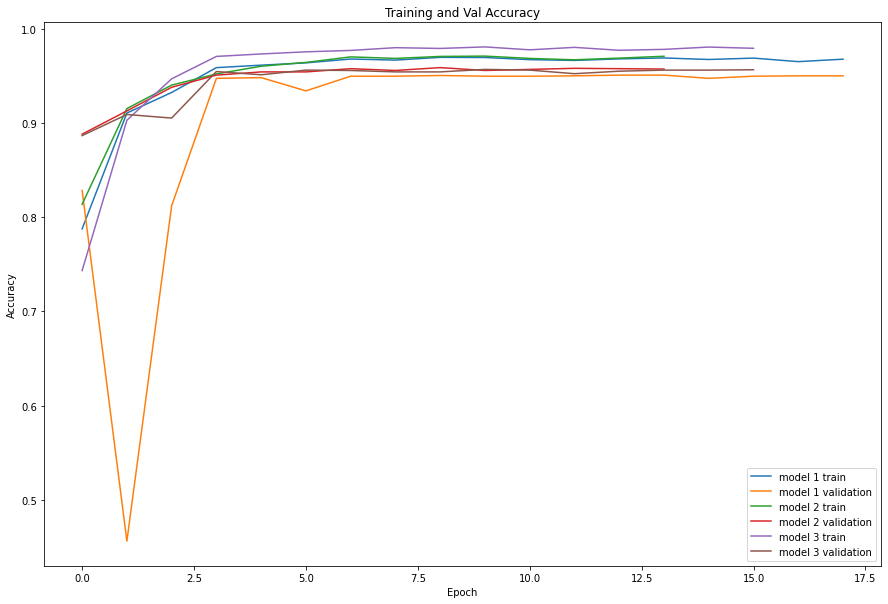

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(range(0,len(result_resnet)), result_resnet['epoch_acc'], label ='model 1 train')
plt.plot(range(0,len(val_result_resnet)), val_result_resnet['epoch_acc'], label ='model 1 validation')
plt.plot(range(0,len(result_dn)), result_dn['epoch_acc'], label ='model 2 train')
plt.plot(range(0,len(val_result_dn)), val_result_dn['epoch_acc'], label ='model 2 validation')
plt.plot(range(0,len(result_wrn)), result_wrn['epoch_acc'], label ='model 3 train')
plt.plot(range(0,len(val_result_wrn)), val_result_wrn['epoch_acc'], label ='model 3 validation')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Val Accuracy')

Text(0.5, 1.0, 'Training and Val Accuracy')

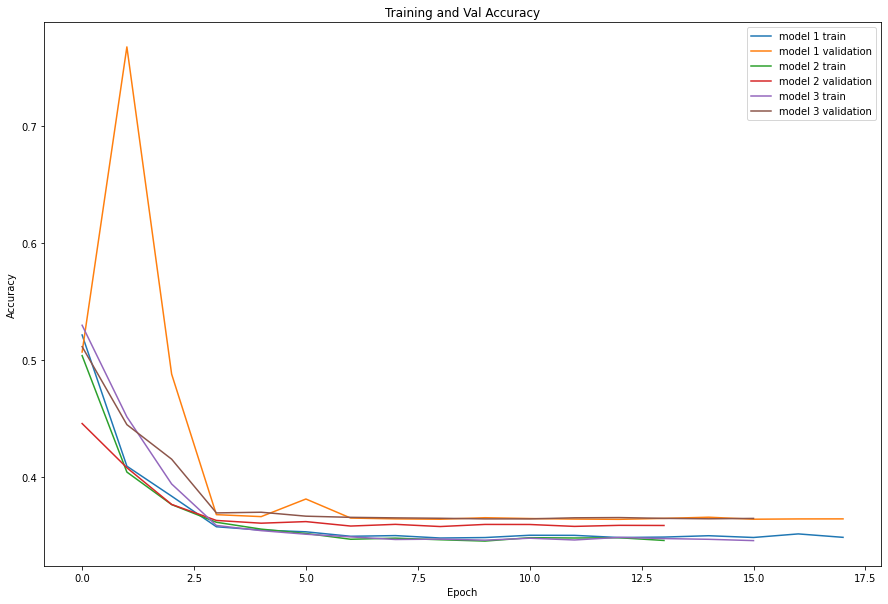

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(range(0,len(result_resnet)), result_resnet['epoch_loss'], label ='model 1 train')
plt.plot(range(0,len(val_result_resnet)), val_result_resnet['epoch_loss'], label ='model 1 validation')
plt.plot(range(0,len(result_dn)), result_dn['epoch_loss'], label ='model 2 train')
plt.plot(range(0,len(val_result_dn)), val_result_dn['epoch_loss'], label ='model 2 validation')
plt.plot(range(0,len(result_wrn)), result_wrn['epoch_loss'], label ='model 3 train')
plt.plot(range(0,len(val_result_wrn)), val_result_wrn['epoch_loss'], label ='model 3 validation')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Val Accuracy')

### Saving result

In [ ]:
torch.save(model_resnet.state_dict(), model_folder + 'model_resnet_sgd_0001.pt')
torch.save(model_dn.state_dict(), model_folder +'model_densenet_sgd_0001.pt')
torch.save(model_wrn.state_dict(), model_folder +'model_wrn_sgd_0001.pt')

In [ ]:
result_resnet['model'] = 'resnet'
result_dn['model'] = 'densenet'
result_wrn['model'] = 'wrn'

val_result_resnet['model'] = 'resnet'
val_result_dn['model'] = 'densenet'
val_result_wrn['model'] = 'wrn'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
best_results = pd.concat([best_record_resnet, best_record_dn, best_record_wrn])
train_result = pd.concat([result_resnet, result_dn, result_wrn])
val_result = pd.concat([val_result_resnet, val_result_dn, val_result_wrn])

In [ ]:
train_result.to_csv(csv_folder+'train_sgd_0001.csv')
val_result.to_csv(csv_folder+'val_sgd_0001.csv')
best_results.to_excel(csv_folder+'best_sgd_0001.xlsx')

##Training Models 0.01

### Resnet50

In [ ]:
model_resnet = pretrained_model('resnet50').to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
model_resnet, history_resnet, best_record_resnet = train_model(model_resnet, dataloaders1, criterion, optimizer, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
Phase train: Acc: 0.8643 | Loss: 0.4467 | Sensitivity: 0.8671 | Specificity: 0.8532
Phase val: Acc: 0.8685 | Loss: 0.4391 | Sensitivity: 0.8488 | Specificity: 0.9820

Epoch 1/49
----------
Phase train: Acc: 0.9112 | Loss: 0.3975 | Sensitivity: 0.9188 | Specificity: 0.8880
Phase val: Acc: 0.8970 | Loss: 0.4151 | Sensitivity: 0.8953 | Specificity: 0.9032

Epoch 2/49
----------
Phase train: Acc: 0.9198 | Loss: 0.3909 | Sensitivity: 0.9261 | Specificity: 0.9010
Phase val: Acc: 0.9069 | Loss: 0.4014 | Sensitivity: 0.9512 | Specificity: 0.8028

Epoch 3/49
----------
Phase train: Acc: 0.9436 | Loss: 0.3686 | Sensitivity: 0.9416 | Specificity: 0.9497
Phase val: Acc: 0.9472 | Loss: 0.3640 | Sensitivity: 0.9452 | Specificity: 0.9533

Epoch 4/49
----------
Phase train: Acc: 0.9567 | Loss: 0.3562 | Sensitivity: 0.9554 | Specificity: 0.9602
Phase val: Acc: 0.9498 | Loss: 0.3620 | Sensitivity: 0.9597 | Specificity: 0.9225

Epoch 5/49
----------
Phase train: Acc: 0.9611 | Loss: 

In [ ]:
best_record_resnet['model'] = 'resnet50'

### densenet201

In [ ]:
model_dn = pretrained_model('densenet201').to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_dn.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
model_dn, history_dn, best_record_dn = train_model(model_dn, dataloaders1, criterion, optimizer, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
Phase train: Acc: 0.8680 | Loss: 0.4425 | Sensitivity: 0.8705 | Specificity: 0.8586
Phase val: Acc: 0.8974 | Loss: 0.4139 | Sensitivity: 0.8879 | Specificity: 0.9362

Epoch 1/49
----------
Phase train: Acc: 0.9037 | Loss: 0.4066 | Sensitivity: 0.9121 | Specificity: 0.8778
Phase val: Acc: 0.8624 | Loss: 0.4449 | Sensitivity: 0.9548 | Specificity: 0.6932

Epoch 2/49
----------
Phase train: Acc: 0.9280 | Loss: 0.3838 | Sensitivity: 0.9331 | Specificity: 0.9130
Phase val: Acc: 0.9255 | Loss: 0.3868 | Sensitivity: 0.9097 | Specificity: 0.9870

Epoch 3/49
----------
Phase train: Acc: 0.9459 | Loss: 0.3659 | Sensitivity: 0.9452 | Specificity: 0.9478
Phase val: Acc: 0.9449 | Loss: 0.3682 | Sensitivity: 0.9637 | Specificity: 0.8956

Epoch 4/49
----------
Phase train: Acc: 0.9581 | Loss: 0.3550 | Sensitivity: 0.9553 | Specificity: 0.9663
Phase val: Acc: 0.9525 | Loss: 0.3595 | Sensitivity: 0.9483 | Specificity: 0.9656

Epoch 5/49
----------
Phase train: Acc: 0.9650 | Loss: 

In [ ]:
best_record_dn['model'] = 'densenet201'

### WRN-50-2

In [ ]:
model_wrn = pretrained_model('wideresnet50').to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_wrn.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
model_wrn, history_wrn, best_record_wrn = train_model(model_wrn, dataloaders2, criterion, optimizer, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
Phase train: Acc: 0.8763 | Loss: 0.4396 | Sensitivity: 0.8752 | Specificity: 0.8807
Phase val: Acc: 0.8886 | Loss: 0.4197 | Sensitivity: 0.8852 | Specificity: 0.9023

Epoch 1/49
----------
Phase train: Acc: 0.9149 | Loss: 0.3966 | Sensitivity: 0.9223 | Specificity: 0.8927
Phase val: Acc: 0.8829 | Loss: 0.4207 | Sensitivity: 0.9567 | Specificity: 0.7355

Epoch 2/49
----------
Phase train: Acc: 0.9260 | Loss: 0.3845 | Sensitivity: 0.9331 | Specificity: 0.9054
Phase val: Acc: 0.9358 | Loss: 0.3732 | Sensitivity: 0.9531 | Specificity: 0.8887

Epoch 3/49
----------
Phase train: Acc: 0.9526 | Loss: 0.3597 | Sensitivity: 0.9512 | Specificity: 0.9566
Phase val: Acc: 0.9479 | Loss: 0.3634 | Sensitivity: 0.9498 | Specificity: 0.9424

Epoch 4/49
----------
Phase train: Acc: 0.9614 | Loss: 0.3516 | Sensitivity: 0.9620 | Specificity: 0.9598
Phase val: Acc: 0.9510 | Loss: 0.3604 | Sensitivity: 0.9527 | Specificity: 0.9458

Epoch 5/49
----------
Phase train: Acc: 0.9672 | Loss: 

In [ ]:
best_record_wrn['model'] = 'wrn-50-2'

### learning curve

In [ ]:
result_resnet = history_resnet[history_resnet.phase == 'train']
val_result_resnet = history_resnet[history_resnet.phase == 'val']

In [ ]:
result_dn = history_dn[history_dn.phase == 'train']
val_result_dn = history_dn[history_dn.phase == 'val']

In [ ]:
result_wrn = history_wrn[history_wrn.phase == 'train']
val_result_wrn = history_wrn[history_wrn.phase == 'val']

Text(0.5, 1.0, 'Training and Val Accuracy')

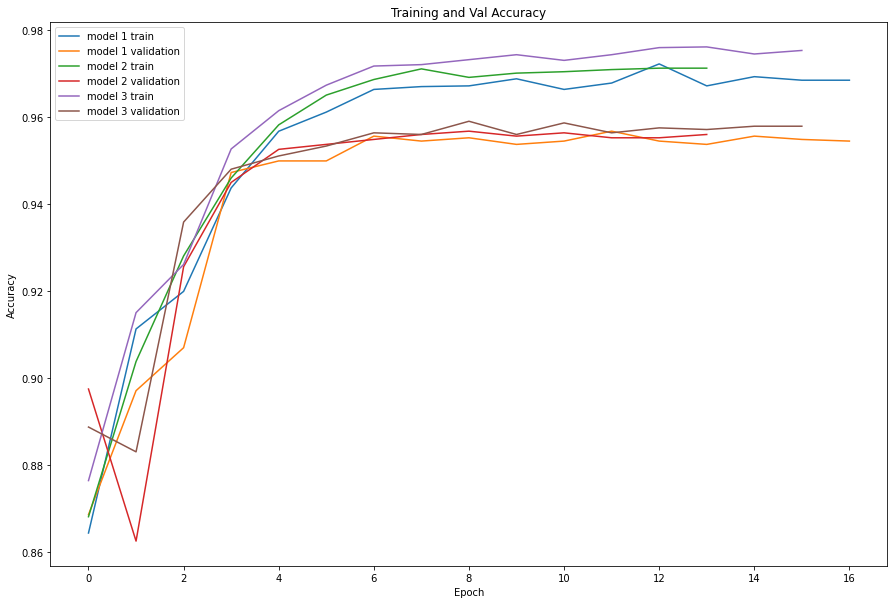

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(range(0,len(result_resnet)), result_resnet['epoch_acc'], label ='model 1 train')
plt.plot(range(0,len(val_result_resnet)), val_result_resnet['epoch_acc'], label ='model 1 validation')
plt.plot(range(0,len(result_dn)), result_dn['epoch_acc'], label ='model 2 train')
plt.plot(range(0,len(val_result_dn)), val_result_dn['epoch_acc'], label ='model 2 validation')
plt.plot(range(0,len(result_wrn)), result_wrn['epoch_acc'], label ='model 3 train')
plt.plot(range(0,len(val_result_wrn)), val_result_wrn['epoch_acc'], label ='model 3 validation')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Val Accuracy')

Text(0.5, 1.0, 'Training and Val Accuracy')

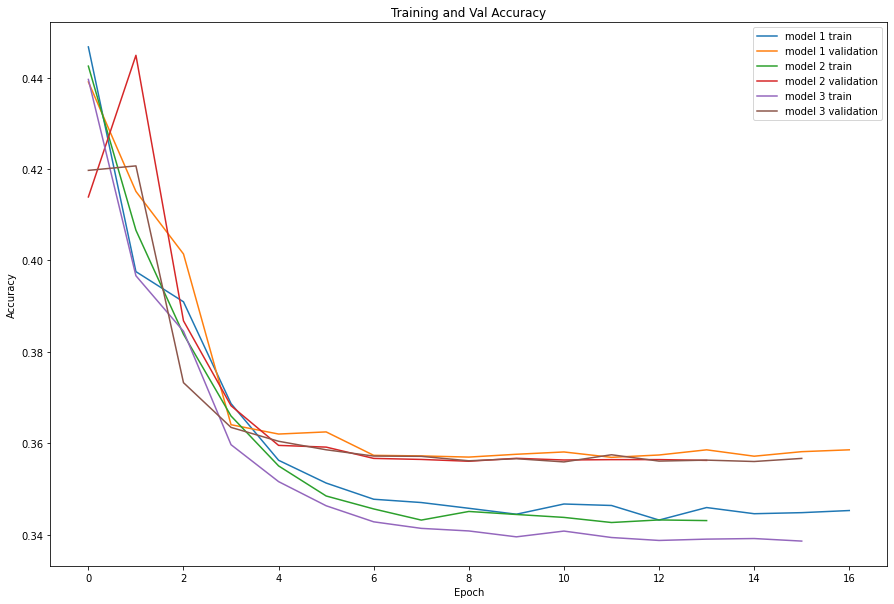

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(range(0,len(result_resnet)), result_resnet['epoch_loss'], label ='model 1 train')
plt.plot(range(0,len(val_result_resnet)), val_result_resnet['epoch_loss'], label ='model 1 validation')
plt.plot(range(0,len(result_dn)), result_dn['epoch_loss'], label ='model 2 train')
plt.plot(range(0,len(val_result_dn)), val_result_dn['epoch_loss'], label ='model 2 validation')
plt.plot(range(0,len(result_wrn)), result_wrn['epoch_loss'], label ='model 3 train')
plt.plot(range(0,len(val_result_wrn)), val_result_wrn['epoch_loss'], label ='model 3 validation')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Val Accuracy')

### Saving result

In [ ]:
torch.save(model_resnet.state_dict(), model_folder+'model_resnet_sgd_001.pt')
torch.save(model_dn.state_dict(), model_folder+'model_densenet_sgd_001.pt')
torch.save(model_wrn.state_dict(), model_folder+'model_wrn_sgd_001.pt')

In [ ]:
result_resnet['model'] = 'resnet'
result_dn['model'] = 'densenet'
result_wrn['model'] = 'wrn'

val_result_resnet['model'] = 'resnet'
val_result_dn['model'] = 'densenet'
val_result_wrn['model'] = 'wrn'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
best_results = pd.concat([best_record_resnet, best_record_dn, best_record_wrn])
train_result = pd.concat([result_resnet, result_dn, result_wrn])
val_result = pd.concat([val_result_resnet, val_result_dn, val_result_wrn])

In [ ]:
train_result.to_csv(csv_folder+'train_sgd_001.csv')
val_result.to_csv(csv_folder+'val_sgd_001.csv')
best_results.to_excel(csv_folder+'best_sgd_001.xlsx')

##Training Models 0.0001

### Resnet50

In [ ]:
model_resnet = pretrained_model('resnet50').to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet.parameters(), lr=0.0001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
model_resnet, history_resnet, best_record_resnet = train_model(model_resnet, dataloaders1, criterion, optimizer, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
Phase train: Acc: 0.6999 | Loss: 0.6119 | Sensitivity: 0.7174 | Specificity: 0.2308
Phase val: Acc: 0.7260 | Loss: 0.5716 | Sensitivity: 0.7260 | Specificity: 0.0000

Epoch 1/49
----------
Phase train: Acc: 0.7192 | Loss: 0.5678 | Sensitivity: 0.7192 | Specificity: 0.0000
Phase val: Acc: 0.7260 | Loss: 0.5512 | Sensitivity: 0.7260 | Specificity: 0.0000

Epoch 2/49
----------
Phase train: Acc: 0.7192 | Loss: 0.5488 | Sensitivity: 0.7192 | Specificity: 0.0000
Phase val: Acc: 0.7260 | Loss: 0.5315 | Sensitivity: 0.7260 | Specificity: 0.0000

Epoch 3/49
----------
Phase train: Acc: 0.7192 | Loss: 0.5379 | Sensitivity: 0.7192 | Specificity: 0.0000
Phase val: Acc: 0.7260 | Loss: 0.5313 | Sensitivity: 0.7260 | Specificity: 0.0000

Epoch 4/49
----------
Phase train: Acc: 0.7192 | Loss: 0.5363 | Sensitivity: 0.7192 | Specificity: 0.0000
Phase val: Acc: 0.7260 | Loss: 0.5289 | Sensitivity: 0.7260 | Specificity: 0.0000

Epoch 5/49
----------
Phase train: Acc: 0.7194 | Loss: 

In [ ]:
best_record_resnet['model'] = 'resnet50'

### densenet201

In [ ]:
model_dn = pretrained_model('densenet201').to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_dn.parameters(), lr=0.0001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
model_dn, history_dn, best_record_dn = train_model(model_dn, dataloaders1, criterion, optimizer, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
Phase train: Acc: 0.7124 | Loss: 0.6058 | Sensitivity: 0.7223 | Specificity: 0.3820
Phase val: Acc: 0.7260 | Loss: 0.5604 | Sensitivity: 0.7260 | Specificity: 0.0000

Epoch 1/49
----------
Phase train: Acc: 0.7192 | Loss: 0.5490 | Sensitivity: 0.7192 | Specificity: 0.0000
Phase val: Acc: 0.7260 | Loss: 0.5283 | Sensitivity: 0.7260 | Specificity: 0.0000

Epoch 2/49
----------
Phase train: Acc: 0.7522 | Loss: 0.5215 | Sensitivity: 0.7440 | Specificity: 0.9856
Phase val: Acc: 0.8255 | Loss: 0.5039 | Sensitivity: 0.8070 | Specificity: 0.9888

Epoch 3/49
----------
Phase train: Acc: 0.8136 | Loss: 0.5077 | Sensitivity: 0.7958 | Specificity: 0.9754
Phase val: Acc: 0.8320 | Loss: 0.5014 | Sensitivity: 0.8129 | Specificity: 0.9895

Epoch 4/49
----------
Phase train: Acc: 0.8208 | Loss: 0.5055 | Sensitivity: 0.8023 | Specificity: 0.9756
Phase val: Acc: 0.8366 | Loss: 0.4984 | Sensitivity: 0.8171 | Specificity: 0.9899

Epoch 5/49
----------
Phase train: Acc: 0.8278 | Loss: 

In [ ]:
best_record_dn['model'] = 'densenet201'

### WRN-50-2

In [ ]:
model_wrn = pretrained_model('wideresnet50').to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_wrn.parameters(), lr=0.0001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
model_wrn, history_wrn, best_record_wrn = train_model(model_wrn, dataloaders2, criterion, optimizer, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
Phase train: Acc: 0.7147 | Loss: 0.6247 | Sensitivity: 0.7187 | Specificity: 0.2200
Phase val: Acc: 0.7260 | Loss: 0.5817 | Sensitivity: 0.7260 | Specificity: 0.0000

Epoch 1/49
----------
Phase train: Acc: 0.7192 | Loss: 0.5709 | Sensitivity: 0.7192 | Specificity: 0.0000
Phase val: Acc: 0.7260 | Loss: 0.5493 | Sensitivity: 0.7260 | Specificity: 0.0000

Epoch 2/49
----------
Phase train: Acc: 0.7192 | Loss: 0.5429 | Sensitivity: 0.7192 | Specificity: 0.0000
Phase val: Acc: 0.7260 | Loss: 0.5243 | Sensitivity: 0.7260 | Specificity: 0.0000

Epoch 3/49
----------
Phase train: Acc: 0.7192 | Loss: 0.5289 | Sensitivity: 0.7192 | Specificity: 0.0000
Phase val: Acc: 0.7260 | Loss: 0.5209 | Sensitivity: 0.7260 | Specificity: 0.0000

Epoch 4/49
----------
Phase train: Acc: 0.7192 | Loss: 0.5265 | Sensitivity: 0.7192 | Specificity: 0.0000
Phase val: Acc: 0.7260 | Loss: 0.5185 | Sensitivity: 0.7260 | Specificity: 0.0000

Epoch 5/49
----------
Phase train: Acc: 0.7192 | Loss: 

In [ ]:
best_record_wrn['model'] = 'wrn-50-2'

### learning curve

In [ ]:
result_resnet = history_resnet[history_resnet.phase == 'train']
val_result_resnet = history_resnet[history_resnet.phase == 'val']

In [ ]:
result_dn = history_dn[history_dn.phase == 'train']
val_result_dn = history_dn[history_dn.phase == 'val']

In [ ]:
result_wrn = history_wrn[history_wrn.phase == 'train']
val_result_wrn = history_wrn[history_wrn.phase == 'val']

Text(0.5, 1.0, 'Training and Val Accuracy')

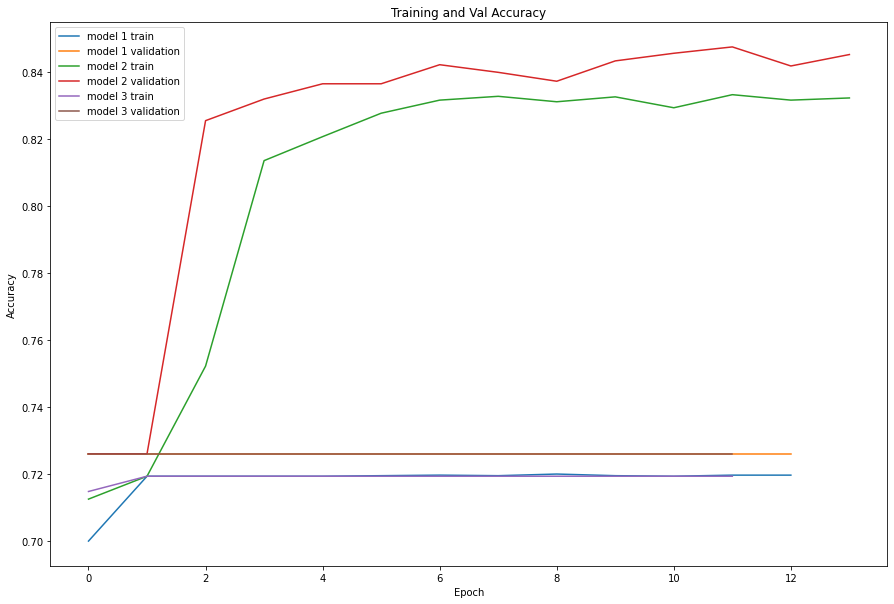

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(range(0,len(result_resnet)), result_resnet['epoch_acc'], label ='model 1 train')
plt.plot(range(0,len(val_result_resnet)), val_result_resnet['epoch_acc'], label ='model 1 validation')
plt.plot(range(0,len(result_dn)), result_dn['epoch_acc'], label ='model 2 train')
plt.plot(range(0,len(val_result_dn)), val_result_dn['epoch_acc'], label ='model 2 validation')
plt.plot(range(0,len(result_wrn)), result_wrn['epoch_acc'], label ='model 3 train')
plt.plot(range(0,len(val_result_wrn)), val_result_wrn['epoch_acc'], label ='model 3 validation')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Val Accuracy')

Text(0.5, 1.0, 'Training and Val Accuracy')

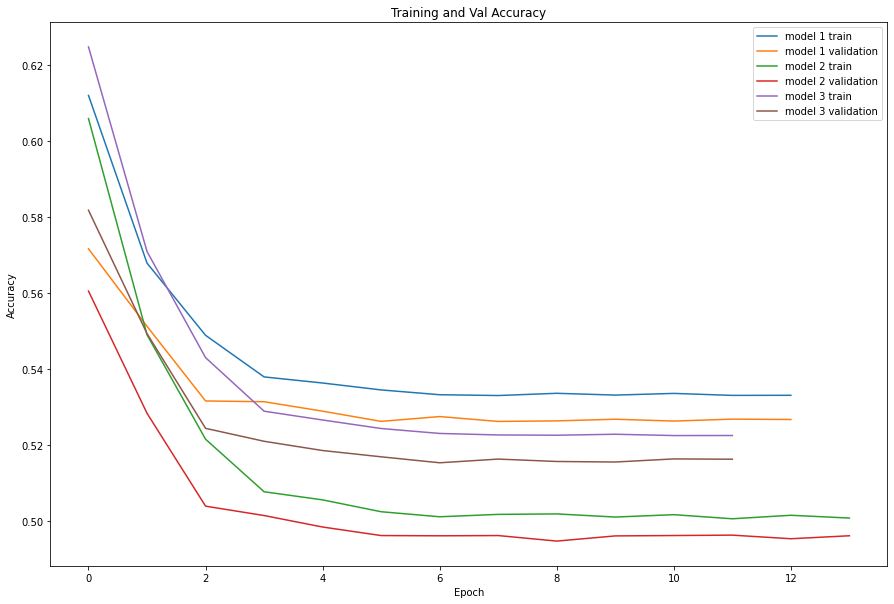

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(range(0,len(result_resnet)), result_resnet['epoch_loss'], label ='model 1 train')
plt.plot(range(0,len(val_result_resnet)), val_result_resnet['epoch_loss'], label ='model 1 validation')
plt.plot(range(0,len(result_dn)), result_dn['epoch_loss'], label ='model 2 train')
plt.plot(range(0,len(val_result_dn)), val_result_dn['epoch_loss'], label ='model 2 validation')
plt.plot(range(0,len(result_wrn)), result_wrn['epoch_loss'], label ='model 3 train')
plt.plot(range(0,len(val_result_wrn)), val_result_wrn['epoch_loss'], label ='model 3 validation')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Val Accuracy')

### Saving result

In [ ]:
torch.save(model_resnet.state_dict(), model_folder+'model_resnet_sgd_00001.pt')
torch.save(model_dn.state_dict(), model_folder+'model_densenet_sgd_00001.pt')
torch.save(model_wrn.state_dict(), model_folder+'model_wrn_sgd_00001.pt')

In [ ]:
result_resnet['model'] = 'resnet'
result_dn['model'] = 'densenet'
result_wrn['model'] = 'wrn'

val_result_resnet['model'] = 'resnet'
val_result_dn['model'] = 'densenet'
val_result_wrn['model'] = 'wrn'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
best_results = pd.concat([best_record_resnet, best_record_dn, best_record_wrn])
train_result = pd.concat([result_resnet, result_dn, result_wrn])
val_result = pd.concat([val_result_resnet, val_result_dn, val_result_wrn])

In [ ]:
train_result.to_csv(csv_folder+'train_sgd_00001.csv')
val_result.to_csv(csv_folder+'val_sgd_00001.csv')
best_results.to_excel(csv_folder+'best_sgd_00001.xlsx')

# ADAM

##Training Models 0.001

### Resnet50

In [ ]:
model_resnet = pretrained_model('resnet50').to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
model_resnet, history_resnet, best_record_resnet = train_model(model_resnet, dataloaders1, criterion, optimizer, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
Phase train: Acc: 0.7220 | Loss: 0.5907 | Sensitivity: 0.7223 | Specificity: 0.6889
Phase val: Acc: 0.7260 | Loss: 0.5873 | Sensitivity: 0.7260 | Specificity: 0.0000

Epoch 1/49
----------
Phase train: Acc: 0.7192 | Loss: 0.5940 | Sensitivity: 0.7192 | Specificity: 0.0000
Phase val: Acc: 0.7260 | Loss: 0.5873 | Sensitivity: 0.7260 | Specificity: 0.0000

Epoch 2/49
----------
Phase train: Acc: 0.7192 | Loss: 0.5940 | Sensitivity: 0.7192 | Specificity: 0.0000
Phase val: Acc: 0.7260 | Loss: 0.5873 | Sensitivity: 0.7260 | Specificity: 0.0000

Epoch 3/49
----------
Phase train: Acc: 0.7192 | Loss: 0.5940 | Sensitivity: 0.7192 | Specificity: 0.0000
Phase val: Acc: 0.7260 | Loss: 0.5873 | Sensitivity: 0.7260 | Specificity: 0.0000

Epoch 4/49
----------
Phase train: Acc: 0.7192 | Loss: 0.5939 | Sensitivity: 0.7192 | Specificity: 0.0000
Phase val: Acc: 0.7256 | Loss: 0.5875 | Sensitivity: 0.7259 | Specificity: 0.0000

Epoch 5/49
----------
Phase train: Acc: 0.7192 | Loss: 

In [ ]:
best_record_resnet['model'] = 'resnet50'

### densenet201

In [ ]:
model_dn = pretrained_model('densenet201').to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_dn.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
model_dn, history_dn, best_record_dn = train_model(model_dn, dataloaders1, criterion, optimizer, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
Phase train: Acc: 0.8371 | Loss: 0.4685 | Sensitivity: 0.8630 | Specificity: 0.7519
Phase val: Acc: 0.7260 | Loss: 0.5873 | Sensitivity: 0.7260 | Specificity: 0.0000

Epoch 1/49
----------
Phase train: Acc: 0.8434 | Loss: 0.4660 | Sensitivity: 0.8639 | Specificity: 0.7737
Phase val: Acc: 0.8024 | Loss: 0.5062 | Sensitivity: 0.9079 | Specificity: 0.6084

Epoch 2/49
----------
Phase train: Acc: 0.8432 | Loss: 0.4655 | Sensitivity: 0.8663 | Specificity: 0.7670
Phase val: Acc: 0.8647 | Loss: 0.4437 | Sensitivity: 0.9129 | Specificity: 0.7437

Epoch 3/49
----------
Phase train: Acc: 0.8696 | Loss: 0.4398 | Sensitivity: 0.8930 | Specificity: 0.7999
Phase val: Acc: 0.8852 | Loss: 0.4223 | Sensitivity: 0.9090 | Specificity: 0.8150

Epoch 4/49
----------
Phase train: Acc: 0.8825 | Loss: 0.4272 | Sensitivity: 0.8955 | Specificity: 0.8413
Phase val: Acc: 0.8921 | Loss: 0.4153 | Sensitivity: 0.9094 | Specificity: 0.8388

Epoch 5/49
----------
Phase train: Acc: 0.8941 | Loss: 

In [ ]:
best_record_dn['model'] = 'densenet201'

### WRN-50-2

In [ ]:
model_wrn = pretrained_model('wideresnet50').to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_wrn.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
model_wrn, history_wrn, best_record_wrn = train_model(model_wrn, dataloaders2, criterion, optimizer, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
Phase train: Acc: 0.7802 | Loss: 0.5261 | Sensitivity: 0.7930 | Specificity: 0.7064
Phase val: Acc: 0.7704 | Loss: 0.5419 | Sensitivity: 0.7637 | Specificity: 0.8774

Epoch 1/49
----------
Phase train: Acc: 0.8384 | Loss: 0.4695 | Sensitivity: 0.8560 | Specificity: 0.7746
Phase val: Acc: 0.8362 | Loss: 0.4714 | Sensitivity: 0.8425 | Specificity: 0.8072

Epoch 2/49
----------
Phase train: Acc: 0.8168 | Loss: 0.4940 | Sensitivity: 0.8209 | Specificity: 0.7962
Phase val: Acc: 0.7260 | Loss: 0.5873 | Sensitivity: 0.7260 | Specificity: 0.0000

Epoch 3/49
----------
Phase train: Acc: 0.7192 | Loss: 0.5939 | Sensitivity: 0.7192 | Specificity: 0.0000
Phase val: Acc: 0.7260 | Loss: 0.5873 | Sensitivity: 0.7260 | Specificity: 0.0000

Epoch 4/49
----------
Phase train: Acc: 0.7194 | Loss: 0.5939 | Sensitivity: 0.7194 | Specificity: 1.0000
Phase val: Acc: 0.7260 | Loss: 0.5873 | Sensitivity: 0.7260 | Specificity: 0.0000

Epoch 5/49
----------
Phase train: Acc: 0.7194 | Loss: 

In [ ]:
best_record_wrn['model'] = 'wrn-50-2'

### learning curve

In [ ]:
result_resnet = history_resnet[history_resnet.phase == 'train']
val_result_resnet = history_resnet[history_resnet.phase == 'val']

In [ ]:
result_dn = history_dn[history_dn.phase == 'train']
val_result_dn = history_dn[history_dn.phase == 'val']

In [ ]:
result_wrn = history_wrn[history_wrn.phase == 'train']
val_result_wrn = history_wrn[history_wrn.phase == 'val']

Text(0.5, 1.0, 'Training and Val Accuracy')

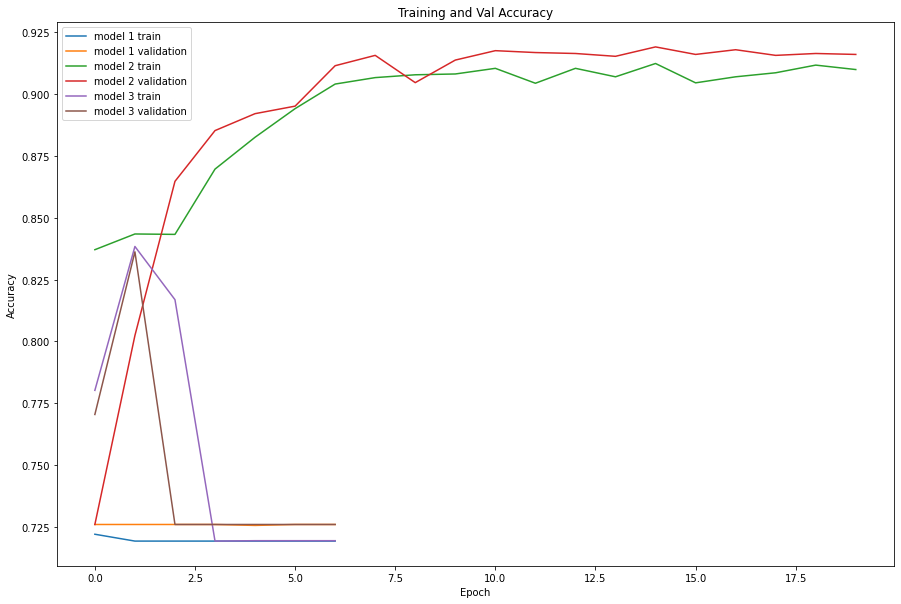

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(range(0,len(result_resnet)), result_resnet['epoch_acc'], label ='model 1 train')
plt.plot(range(0,len(val_result_resnet)), val_result_resnet['epoch_acc'], label ='model 1 validation')
plt.plot(range(0,len(result_dn)), result_dn['epoch_acc'], label ='model 2 train')
plt.plot(range(0,len(val_result_dn)), val_result_dn['epoch_acc'], label ='model 2 validation')
plt.plot(range(0,len(result_wrn)), result_wrn['epoch_acc'], label ='model 3 train')
plt.plot(range(0,len(val_result_wrn)), val_result_wrn['epoch_acc'], label ='model 3 validation')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Val Accuracy')

Text(0.5, 1.0, 'Training and Val Accuracy')

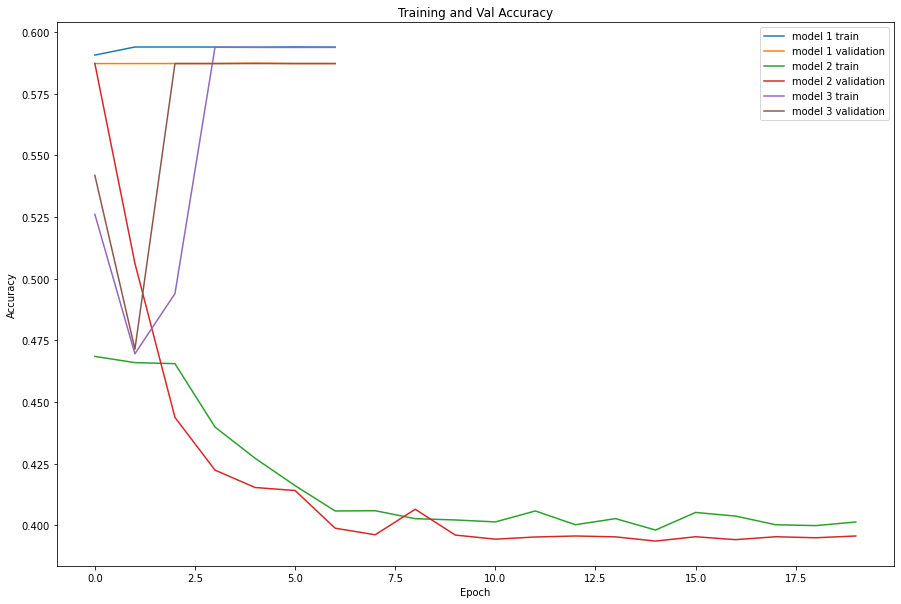

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(range(0,len(result_resnet)), result_resnet['epoch_loss'], label ='model 1 train')
plt.plot(range(0,len(val_result_resnet)), val_result_resnet['epoch_loss'], label ='model 1 validation')
plt.plot(range(0,len(result_dn)), result_dn['epoch_loss'], label ='model 2 train')
plt.plot(range(0,len(val_result_dn)), val_result_dn['epoch_loss'], label ='model 2 validation')
plt.plot(range(0,len(result_wrn)), result_wrn['epoch_loss'], label ='model 3 train')
plt.plot(range(0,len(val_result_wrn)), val_result_wrn['epoch_loss'], label ='model 3 validation')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Val Accuracy')

### Saving result

In [ ]:
torch.save(model_resnet.state_dict(), model_folder+'model_resnet_adam_0001.pt')
torch.save(model_dn.state_dict(), model_folder+'model_densenet_adam_0001.pt')
torch.save(model_wrn.state_dict(), model_folder+'model_wrn_adam_0001.pt')

In [ ]:
result_resnet['model'] = 'resnet'
result_dn['model'] = 'densenet'
result_wrn['model'] = 'wrn'

val_result_resnet['model'] = 'resnet'
val_result_dn['model'] = 'densenet'
val_result_wrn['model'] = 'wrn'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
best_results = pd.concat([best_record_resnet, best_record_dn, best_record_wrn])
train_result = pd.concat([result_resnet, result_dn, result_wrn])
val_result = pd.concat([val_result_resnet, val_result_dn, val_result_wrn])

In [ ]:
train_result.to_csv(csv_folder+'train_adam_0001.csv')
val_result.to_csv(csv_folder+'val_adam_0001.csv')
best_results.to_excel(csv_folder+'best_adam_0001.xlsx')

##Training Models 0.01

### Resnet50

In [ ]:
model_resnet = pretrained_model('resnet50').to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
model_resnet, history_resnet, best_record_resnet = train_model(model_resnet, dataloaders1, criterion, optimizer, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
Phase train: Acc: 0.7188 | Loss: 0.5945 | Sensitivity: 0.7194 | Specificity: 0.3636
Phase val: Acc: 0.7260 | Loss: 0.5873 | Sensitivity: 0.7260 | Specificity: 0.0000

Epoch 1/49
----------
Phase train: Acc: 0.7192 | Loss: 0.5940 | Sensitivity: 0.7192 | Specificity: 0.0000
Phase val: Acc: 0.7260 | Loss: 0.5873 | Sensitivity: 0.7260 | Specificity: 0.0000

Epoch 2/49
----------
Phase train: Acc: 0.7192 | Loss: 0.5940 | Sensitivity: 0.7192 | Specificity: 0.0000
Phase val: Acc: 0.7260 | Loss: 0.5873 | Sensitivity: 0.7260 | Specificity: 0.0000

Epoch 3/49
----------
Phase train: Acc: 0.7192 | Loss: 0.5940 | Sensitivity: 0.7192 | Specificity: 0.0000
Phase val: Acc: 0.7260 | Loss: 0.5873 | Sensitivity: 0.7260 | Specificity: 0.0000

Epoch 4/49
----------
Phase train: Acc: 0.7192 | Loss: 0.5940 | Sensitivity: 0.7192 | Specificity: 0.0000
Phase val: Acc: 0.7260 | Loss: 0.5873 | Sensitivity: 0.7260 | Specificity: 0.0000

Epoch 5/49
----------
Phase train: Acc: 0.7192 | Loss: 

In [ ]:
best_record_resnet['model'] = 'resnet50'

### densenet201

In [ ]:
model_dn = pretrained_model('densenet201').to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_dn.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
model_dn, history_dn, best_record_dn = train_model(model_dn, dataloaders1, criterion, optimizer, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
Phase train: Acc: 0.7192 | Loss: 0.5941 | Sensitivity: 0.7192 | Specificity: 0.0000
Phase val: Acc: 0.7260 | Loss: 0.5873 | Sensitivity: 0.7260 | Specificity: 0.0000

Epoch 1/49
----------
Phase train: Acc: 0.7192 | Loss: 0.5940 | Sensitivity: 0.7192 | Specificity: 0.0000
Phase val: Acc: 0.7260 | Loss: 0.5873 | Sensitivity: 0.7260 | Specificity: 0.0000

Epoch 2/49
----------
Phase train: Acc: 0.7192 | Loss: 0.5940 | Sensitivity: 0.7192 | Specificity: 0.0000
Phase val: Acc: 0.7260 | Loss: 0.5873 | Sensitivity: 0.7260 | Specificity: 0.0000

Epoch 3/49
----------
Phase train: Acc: 0.7192 | Loss: 0.5940 | Sensitivity: 0.7192 | Specificity: 0.0000
Phase val: Acc: 0.7260 | Loss: 0.5873 | Sensitivity: 0.7260 | Specificity: 0.0000

Epoch 4/49
----------
Phase train: Acc: 0.7192 | Loss: 0.5940 | Sensitivity: 0.7192 | Specificity: 0.0000
Phase val: Acc: 0.7260 | Loss: 0.5873 | Sensitivity: 0.7260 | Specificity: 0.0000

Epoch 5/49
----------
Phase train: Acc: 0.7192 | Loss: 

In [ ]:
best_record_dn['model'] = 'densenet201'

### WRN-50-2

In [ ]:
model_wrn = pretrained_model('wideresnet50').to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_wrn.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
model_wrn, history_wrn, best_record_wrn = train_model(model_wrn, dataloaders2, criterion, optimizer, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
Phase train: Acc: 0.7183 | Loss: 0.5941 | Sensitivity: 0.7190 | Specificity: 0.1250
Phase val: Acc: 0.7260 | Loss: 0.5873 | Sensitivity: 0.7260 | Specificity: 0.0000

Epoch 1/49
----------
Phase train: Acc: 0.7192 | Loss: 0.5940 | Sensitivity: 0.7192 | Specificity: 0.0000
Phase val: Acc: 0.7260 | Loss: 0.5873 | Sensitivity: 0.7260 | Specificity: 0.0000

Epoch 2/49
----------
Phase train: Acc: 0.7192 | Loss: 0.5940 | Sensitivity: 0.7192 | Specificity: 0.0000
Phase val: Acc: 0.7260 | Loss: 0.5873 | Sensitivity: 0.7260 | Specificity: 0.0000

Epoch 3/49
----------
Phase train: Acc: 0.7192 | Loss: 0.5940 | Sensitivity: 0.7192 | Specificity: 0.0000
Phase val: Acc: 0.7260 | Loss: 0.5873 | Sensitivity: 0.7260 | Specificity: 0.0000

Epoch 4/49
----------
Phase train: Acc: 0.7192 | Loss: 0.5940 | Sensitivity: 0.7192 | Specificity: 0.0000
Phase val: Acc: 0.7260 | Loss: 0.5873 | Sensitivity: 0.7260 | Specificity: 0.0000

Epoch 5/49
----------
Phase train: Acc: 0.7192 | Loss: 

In [ ]:
best_record_wrn['model'] = 'wrn-50-2'

### learning curve

In [ ]:
result_resnet = history_resnet[history_resnet.phase == 'train']
val_result_resnet = history_resnet[history_resnet.phase == 'val']

In [ ]:
result_dn = history_dn[history_dn.phase == 'train']
val_result_dn = history_dn[history_dn.phase == 'val']

In [ ]:
result_wrn = history_wrn[history_wrn.phase == 'train']
val_result_wrn = history_wrn[history_wrn.phase == 'val']

Text(0.5, 1.0, 'Training and Val Accuracy')

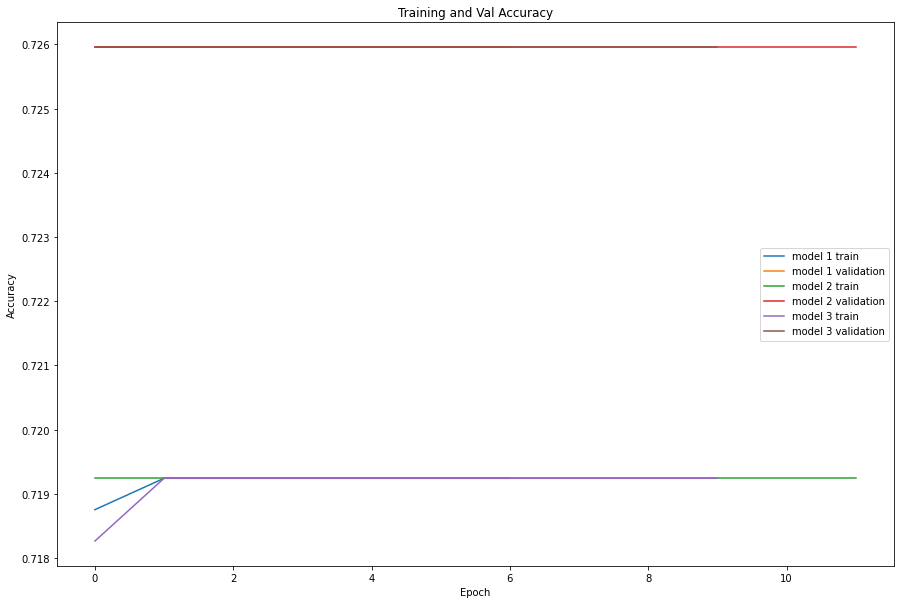

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(range(0,len(result_resnet)), result_resnet['epoch_acc'], label ='model 1 train')
plt.plot(range(0,len(val_result_resnet)), val_result_resnet['epoch_acc'], label ='model 1 validation')
plt.plot(range(0,len(result_dn)), result_dn['epoch_acc'], label ='model 2 train')
plt.plot(range(0,len(val_result_dn)), val_result_dn['epoch_acc'], label ='model 2 validation')
plt.plot(range(0,len(result_wrn)), result_wrn['epoch_acc'], label ='model 3 train')
plt.plot(range(0,len(val_result_wrn)), val_result_wrn['epoch_acc'], label ='model 3 validation')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Val Accuracy')

Text(0.5, 1.0, 'Training and Val Accuracy')

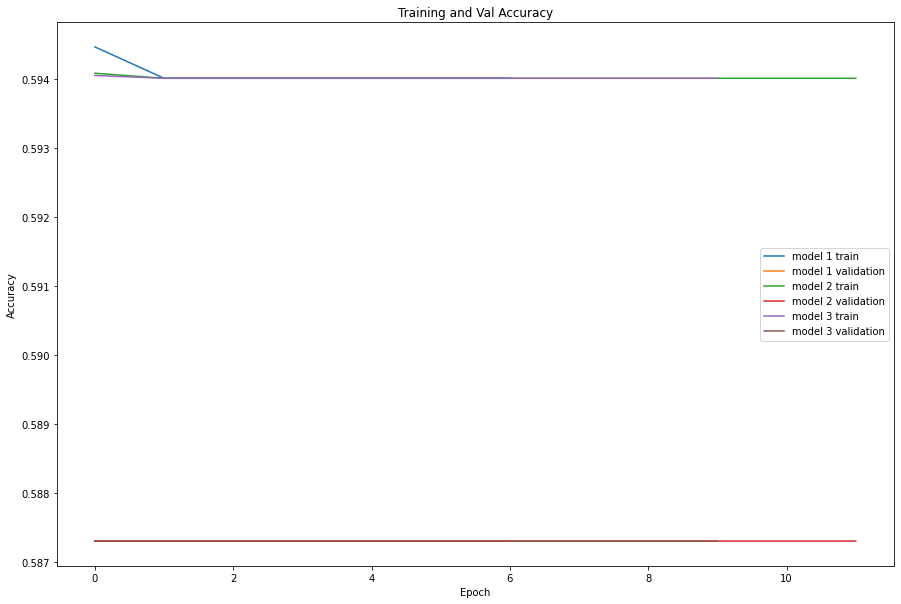

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(range(0,len(result_resnet)), result_resnet['epoch_loss'], label ='model 1 train')
plt.plot(range(0,len(val_result_resnet)), val_result_resnet['epoch_loss'], label ='model 1 validation')
plt.plot(range(0,len(result_dn)), result_dn['epoch_loss'], label ='model 2 train')
plt.plot(range(0,len(val_result_dn)), val_result_dn['epoch_loss'], label ='model 2 validation')
plt.plot(range(0,len(result_wrn)), result_wrn['epoch_loss'], label ='model 3 train')
plt.plot(range(0,len(val_result_wrn)), val_result_wrn['epoch_loss'], label ='model 3 validation')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Val Accuracy')

### Saving result

In [ ]:
torch.save(model_resnet.state_dict(), model_folder+'model_resnet_adam_001.pt')
torch.save(model_dn.state_dict(), model_folder+'model_densenet_adam_001.pt')
torch.save(model_wrn.state_dict(), model_folder+'model_wrn_adam_001.pt')

In [ ]:
result_resnet['model'] = 'resnet'
result_dn['model'] = 'densenet'
result_wrn['model'] = 'wrn'

val_result_resnet['model'] = 'resnet'
val_result_dn['model'] = 'densenet'
val_result_wrn['model'] = 'wrn'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
best_results = pd.concat([best_record_resnet, best_record_dn, best_record_wrn])
train_result = pd.concat([result_resnet, result_dn, result_wrn])
val_result = pd.concat([val_result_resnet, val_result_dn, val_result_wrn])

In [ ]:
train_result.to_csv(csv_folder+'train_adam_001.csv')
val_result.to_csv(csv_folder+'val_adam_001.csv')
best_results.to_excel(csv_folder+'best_adam_001.xlsx')

##Training Models 0.0001

### Resnet50

In [ ]:
model_resnet = pretrained_model('resnet50').to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
model_resnet, history_resnet, best_record_resnet = train_model(model_resnet, dataloaders1, criterion, optimizer, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
Phase train: Acc: 0.8910 | Loss: 0.4185 | Sensitivity: 0.8948 | Specificity: 0.8780
Phase val: Acc: 0.9297 | Loss: 0.3823 | Sensitivity: 0.9268 | Specificity: 0.9393

Epoch 1/49
----------
Phase train: Acc: 0.9247 | Loss: 0.3850 | Sensitivity: 0.9330 | Specificity: 0.9008
Phase val: Acc: 0.8510 | Loss: 0.4551 | Sensitivity: 0.8370 | Specificity: 0.9340

Epoch 2/49
----------
Phase train: Acc: 0.9373 | Loss: 0.3739 | Sensitivity: 0.9472 | Specificity: 0.9099
Phase val: Acc: 0.9426 | Loss: 0.3690 | Sensitivity: 0.9513 | Specificity: 0.9179

Epoch 3/49
----------
Phase train: Acc: 0.9576 | Loss: 0.3554 | Sensitivity: 0.9583 | Specificity: 0.9558
Phase val: Acc: 0.9559 | Loss: 0.3566 | Sensitivity: 0.9553 | Specificity: 0.9576

Epoch 4/49
----------
Phase train: Acc: 0.9637 | Loss: 0.3489 | Sensitivity: 0.9647 | Specificity: 0.9607
Phase val: Acc: 0.9571 | Loss: 0.3550 | Sensitivity: 0.9531 | Specificity: 0.9691

Epoch 5/49
----------
Phase train: Acc: 0.9702 | Loss: 

In [ ]:
best_record_resnet['model'] = 'resnet50'

### densenet201

In [ ]:
model_dn = pretrained_model('densenet201').to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_dn.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
model_dn, history_dn, best_record_dn = train_model(model_dn, dataloaders1, criterion, optimizer, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
Phase train: Acc: 0.8929 | Loss: 0.4181 | Sensitivity: 0.8982 | Specificity: 0.8754
Phase val: Acc: 0.9240 | Loss: 0.3864 | Sensitivity: 0.9509 | Specificity: 0.8544

Epoch 1/49
----------
Phase train: Acc: 0.9316 | Loss: 0.3794 | Sensitivity: 0.9410 | Specificity: 0.9049
Phase val: Acc: 0.5405 | Loss: 0.7553 | Sensitivity: 0.9782 | Specificity: 0.3714

Epoch 2/49
----------
Phase train: Acc: 0.9420 | Loss: 0.3699 | Sensitivity: 0.9471 | Specificity: 0.9275
Phase val: Acc: 0.6435 | Loss: 0.6483 | Sensitivity: 0.9860 | Specificity: 0.4335

Epoch 3/49
----------
Phase train: Acc: 0.9663 | Loss: 0.3472 | Sensitivity: 0.9653 | Specificity: 0.9691
Phase val: Acc: 0.9635 | Loss: 0.3501 | Sensitivity: 0.9637 | Specificity: 0.9630

Epoch 4/49
----------
Phase train: Acc: 0.9733 | Loss: 0.3398 | Sensitivity: 0.9720 | Specificity: 0.9768
Phase val: Acc: 0.9666 | Loss: 0.3469 | Sensitivity: 0.9657 | Specificity: 0.9689

Epoch 5/49
----------
Phase train: Acc: 0.9760 | Loss: 

In [ ]:
best_record_dn['model'] = 'densenet201'

### WRN-50-2

In [ ]:
model_wrn = pretrained_model('wideresnet50').to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_wrn.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
model_wrn, history_wrn, best_record_wrn = train_model(model_wrn, dataloaders2, criterion, optimizer, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
Phase train: Acc: 0.8991 | Loss: 0.4099 | Sensitivity: 0.9047 | Specificity: 0.8812
Phase val: Acc: 0.9133 | Loss: 0.3951 | Sensitivity: 0.9507 | Specificity: 0.8222

Epoch 1/49
----------
Phase train: Acc: 0.9260 | Loss: 0.3849 | Sensitivity: 0.9344 | Specificity: 0.9018
Phase val: Acc: 0.9365 | Loss: 0.3754 | Sensitivity: 0.9274 | Specificity: 0.9679

Epoch 2/49
----------
Phase train: Acc: 0.9358 | Loss: 0.3754 | Sensitivity: 0.9406 | Specificity: 0.9219
Phase val: Acc: 0.7263 | Loss: 0.5787 | Sensitivity: 0.9521 | Specificity: 0.5004

Epoch 3/49
----------
Phase train: Acc: 0.9606 | Loss: 0.3521 | Sensitivity: 0.9593 | Specificity: 0.9643
Phase val: Acc: 0.9578 | Loss: 0.3544 | Sensitivity: 0.9658 | Specificity: 0.9357

Epoch 4/49
----------
Phase train: Acc: 0.9682 | Loss: 0.3446 | Sensitivity: 0.9676 | Specificity: 0.9699
Phase val: Acc: 0.9609 | Loss: 0.3540 | Sensitivity: 0.9575 | Specificity: 0.9710

Epoch 5/49
----------
Phase train: Acc: 0.9710 | Loss: 

In [ ]:
best_record_wrn['model'] = 'wrn-50-2'

### learning curve

In [ ]:
result_resnet = history_resnet[history_resnet.phase == 'train']
val_result_resnet = history_resnet[history_resnet.phase == 'val']

In [ ]:
result_dn = history_dn[history_dn.phase == 'train']
val_result_dn = history_dn[history_dn.phase == 'val']

In [ ]:
result_wrn = history_wrn[history_wrn.phase == 'train']
val_result_wrn = history_wrn[history_wrn.phase == 'val']

Text(0.5, 1.0, 'Training and Val Accuracy')

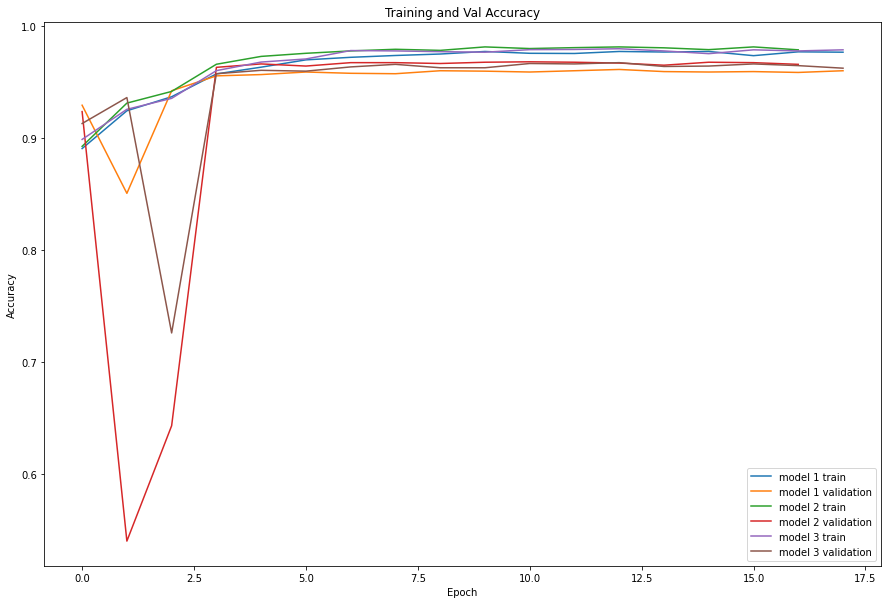

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(range(0,len(result_resnet)), result_resnet['epoch_acc'], label ='model 1 train')
plt.plot(range(0,len(val_result_resnet)), val_result_resnet['epoch_acc'], label ='model 1 validation')
plt.plot(range(0,len(result_dn)), result_dn['epoch_acc'], label ='model 2 train')
plt.plot(range(0,len(val_result_dn)), val_result_dn['epoch_acc'], label ='model 2 validation')
plt.plot(range(0,len(result_wrn)), result_wrn['epoch_acc'], label ='model 3 train')
plt.plot(range(0,len(val_result_wrn)), val_result_wrn['epoch_acc'], label ='model 3 validation')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Val Accuracy')

Text(0.5, 1.0, 'Training and Val Accuracy')

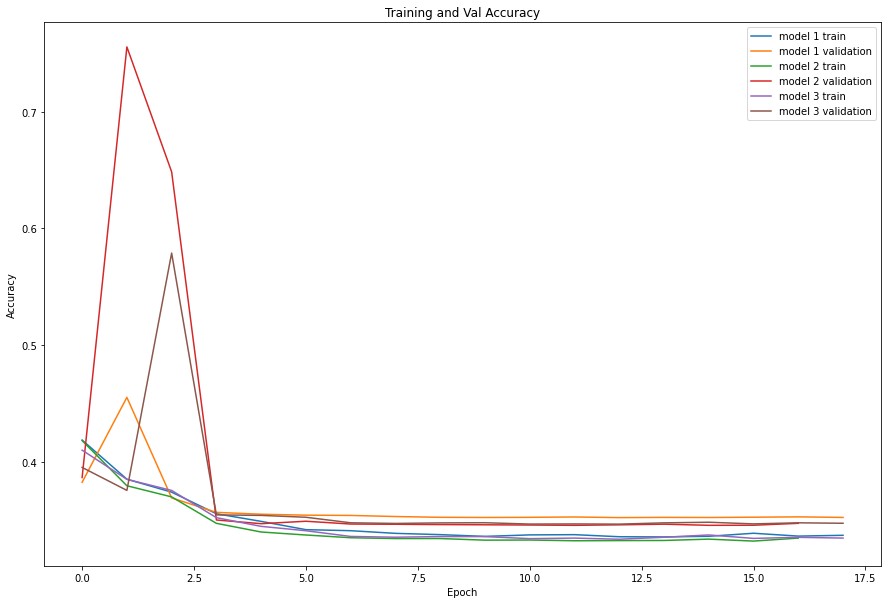

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(range(0,len(result_resnet)), result_resnet['epoch_loss'], label ='model 1 train')
plt.plot(range(0,len(val_result_resnet)), val_result_resnet['epoch_loss'], label ='model 1 validation')
plt.plot(range(0,len(result_dn)), result_dn['epoch_loss'], label ='model 2 train')
plt.plot(range(0,len(val_result_dn)), val_result_dn['epoch_loss'], label ='model 2 validation')
plt.plot(range(0,len(result_wrn)), result_wrn['epoch_loss'], label ='model 3 train')
plt.plot(range(0,len(val_result_wrn)), val_result_wrn['epoch_loss'], label ='model 3 validation')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Val Accuracy')

### Saving result

In [ ]:
torch.save(model_resnet.state_dict(), model_folder+'model_resnet_adam_00001.pt')
torch.save(model_dn.state_dict(), model_folder+'model_densenet_adam_00001.pt')
torch.save(model_wrn.state_dict(), model_folder+'model_wrn_adam_00001.pt')

In [ ]:
result_resnet['model'] = 'resnet'
result_dn['model'] = 'densenet'
result_wrn['model'] = 'wrn'

val_result_resnet['model'] = 'resnet'
val_result_dn['model'] = 'densenet'
val_result_wrn['model'] = 'wrn'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
best_results = pd.concat([best_record_resnet, best_record_dn, best_record_wrn])
train_result = pd.concat([result_resnet, result_dn, result_wrn])
val_result = pd.concat([val_result_resnet, val_result_dn, val_result_wrn])

In [ ]:
train_result.to_csv(csv_folder+'train_adam_00001.csv')
val_result.to_csv(csv_folder+'val_adam_00001.csv')
best_results.to_excel(csv_folder+'best_adam_00001.xlsx')